In [351]:
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

In [332]:
df = pd.read_csv("syri_i90_l100/syri.summary", sep="\t", header=None, comment="#")
df.columns = ["variation_type", "count", "length_ref", "length_query"]
df = df.iloc[:7,:]
df.replace("-", np.nan, inplace=True)

df["length_ref"] = pd.to_numeric(df["length_ref"], errors="coerce")
df["length_query"] = pd.to_numeric(df["length_query"], errors="coerce")

#combine duplications rows
duplications_row = df[df["variation_type"].str.contains("Duplications")].sum(numeric_only=True)
duplications_row["variation_type"] = "Duplications"
duplications_row["length_ref"] = df.loc[df["variation_type"].str.contains("Duplications"), "length_ref"].sum()
duplications_row["length_query"] = df.loc[df["variation_type"].str.contains("Duplications"), "length_query"].sum()
duplications_df = pd.DataFrame([duplications_row])
# combine not aligned rows
not_aligned_row = df[df["variation_type"].str.contains("Not aligned")].sum(numeric_only=True)
not_aligned_row["variation_type"] = "Not aligned"
not_aligned_row["length_ref"] = df.loc[df["variation_type"].str.contains("Not aligned"), "length_ref"].sum()
not_aligned_row["length_query"] = df.loc[df["variation_type"].str.contains("Not aligned"), "length_query"].sum()
not_aligned_df = pd.DataFrame([not_aligned_row])

df = df[~df["variation_type"].str.contains("Duplications|Not aligned")]
df = pd.concat([df, duplications_df, not_aligned_df], ignore_index=True)
df = df.melt(id_vars="variation_type", value_vars=["length_ref", "length_query"], var_name="length_type", value_name="length")
df

,variation_type,length_type,length
0,Syntenic regions,length_ref,60169458.0
1,Inversions,length_ref,299021.0
2,Translocations,length_ref,3329389.0
3,Duplications,length_ref,4223219.0
4,Not aligned,length_ref,9726962.0
5,Syntenic regions,length_query,60051366.0
6,Inversions,length_query,278724.0
7,Translocations,length_query,3182372.0
8,Duplications,length_query,2490040.0
9,Not aligned,length_query,9084758.0


Text(0.5, 0, '')

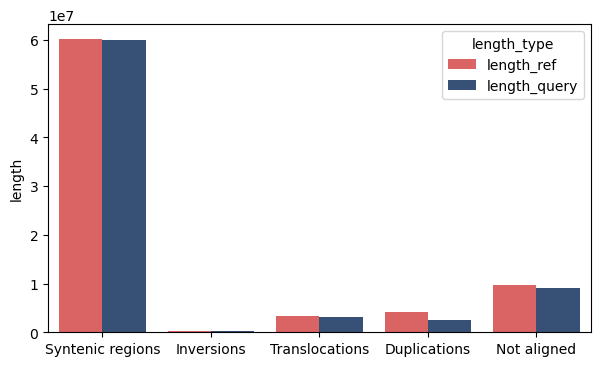

In [345]:
plt.figure(figsize=(7,4))
sns.barplot(x="variation_type", y="length", hue="length_type", data=df, palette=["#ee4f4f", "#2d4f80"])
plt.xlabel("", fontsize=9)

In [355]:
syri = pd.read_csv("syri_i90_l100/syri.out", sep="\t", header=None)
syri.columns = ["ref_chr", "ref_start", "ref_end", "ref_seq", "query_seq", "query_chr", 
                "query_start", "query_end", "unique_id", "parent_id", "anno_type", "copy_stat_for_dup"]

syri.replace("-", np.nan, inplace=True)
syri["ref_start"] = pd.to_numeric(syri["ref_start"], errors="coerce").astype(pd.Int64Dtype())
syri["ref_end"] = pd.to_numeric(syri["ref_end"], errors="coerce").astype(pd.Int64Dtype())
syri["query_start"] = pd.to_numeric(syri["query_start"], errors="coerce").astype(pd.Int64Dtype())
syri["query_end"] = pd.to_numeric(syri["query_end"], errors="coerce").astype(pd.Int64Dtype())
syri["anno_type"].value_counts()
syri

/tmp/ipykernel_2474767/3967108213.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  syri = pd.read_csv("syri_i90_l100/syri.out", sep="\t", header=None)


,ref_chr,ref_start,ref_end,ref_seq,query_seq,query_chr,query_start,query_end,unique_id,parent_id,anno_type,copy_stat_for_dup
0,chr10A,1,549,NaN,NaN,NaN,<NA>,<NA>,NOTAL1,NaN,NOTAL,NaN
1,chr10A,550,2277,NaN,NaN,chr13B,261,2105,DUP1581,NaN,DUP,copyloss
2,chr10A,550,2277,NaN,NaN,chr13B,261,2105,DUPAL3207,DUP1581,DUPAL,NaN
3,chr10A,2275,4834,NaN,NaN,chr16B,1184869,1187425,DUP1582,NaN,DUP,copyloss
4,chr10A,2275,4834,NaN,NaN,chr16B,1184869,1187425,DUPAL3208,DUP1582,DUPAL,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
621451,NaN,<NA>,<NA>,NaN,NaN,chr9B,4147637,4150568,NOTAL2699,NaN,NOTAL,NaN
621452,NaN,<NA>,<NA>,NaN,NaN,chr9B,4497248,4497492,NOTAL2700,NaN,NOTAL,NaN
621453,NaN,<NA>,<NA>,NaN,NaN,chr9B,4514567,4516078,NOTAL2701,NaN,NOTAL,NaN
621454,NaN,<NA>,<NA>,NaN,NaN,chr9B,4522456,4536848,NOTAL2702,NaN,NOTAL,NaN


In [374]:
def split_sv_types(df, indel_length_threshsold=50):
    sv_dict = {}
    
    for sv_type, name in {"SYN": "syntenic_region",
                          "INV": "inversion",
                          "NOTAL": "not_aligned"}.items():
        if sv_type in df["anno_type"].values:
            tmp = df[df["anno_type"]==sv_type].copy()
            tmp["ref_len"] = tmp["ref_end"]-tmp["ref_start"]+1
            tmp["query_len"] = tmp["query_end"]-tmp["query_start"]+1
            tmp["category"] = name
            sv_dict[name] = tmp
    
    if df["anno_type"].isin(["TRANS", "INVTR"]).any():
        tmp = df[df["anno_type"].isin(["TRANS", "INVTR"])].copy()
        tmp["ref_len"] = tmp["ref_end"]-tmp["ref_start"]+1
        tmp["query_len"] = tmp["query_end"]-tmp["query_start"]+1
        tmp["category"] = "translocation"
        sv_dict["translocation"] = tmp
        
    if df["anno_type"].isin(["DUP", "INVDP"]).any():
        tmp = df[df["anno_type"].isin(["DUP", "INVDP"])]
        ref_dup = tmp[tmp["copy_stat_for_dup"]=="copyloss"].copy()
        query_dup = tmp[tmp["copy_stat_for_dup"]=="copygain"].copy()
        ref_dup["ref_len"] = tmp["ref_end"]-tmp["ref_start"]+1
        query_dup["query_len"] = tmp["query_end"]-tmp["query_start"]+1
        ref_dup["category"] = "duplication"
        query_dup["category"] = "duplication"
        sv_dict["duplication"] = pd.concat([ref_dup,query_dup], axis=0)
        
    if "INS" in df["anno_type"].values:
        tmp = df[df["anno_type"] == "INS"].copy()
        tmp["query_len"] = tmp["query_end"]-tmp["query_start"]
        tmp["category"] = "insertion"
        sv_dict["insertion"] = tmp[tmp["query_len"]>=indel_length_threshsold]
        
    if "DEL" in df["anno_type"].values:
        tmp = df[df["anno_type"] == "DEL"].copy()
        tmp["ref_len"] = tmp["ref_end"]-tmp["ref_start"]
        tmp["category"] = "deletion"
        sv_dict["deletion"] = tmp[tmp["ref_len"]>=indel_length_threshsold]
        
    return sv_dict


def average_sv_length_between_ref_query(row):
    ref_len = row["ref_len"]
    query_len = row["query_len"]
    
    if pd.isna(ref_len) and pd.isna(query_len):
        return np.nan
    elif pd.isna(ref_len):
        return query_len
    elif pd.isna(query_len):
        return ref_len
    else:
        return (ref_len+query_len)/2

In [375]:
syri_split_dict = split_sv_types(syri)
syri_refined = pd.concat(list(syri_split_dict.values()), axis=0)
syri_refined["log10(length)"] = np.log10(syri_refined.apply(average_sv_length_between_ref_query, axis=1))
syri_refined["length"] = syri_refined.apply(average_sv_length_between_ref_query, axis=1)
syri_refined

,ref_chr,ref_start,ref_end,ref_seq,query_seq,query_chr,query_start,query_end,unique_id,parent_id,anno_type,copy_stat_for_dup,ref_len,query_len,category,log10(length),length
6,chr10A,15890,85363,NaN,NaN,chr10B,254,70705,SYN1,NaN,SYN,NaN,69474,70452,syntenic_region,4.844868,69963.0
849,chr10A,92716,98583,NaN,NaN,chr10B,80769,86665,SYN2,NaN,SYN,NaN,5868,5897,syntenic_region,3.769562,5882.5
992,chr10A,98578,118784,NaN,NaN,chr10B,92582,112881,SYN3,NaN,SYN,NaN,20207,20300,syntenic_region,4.306500,20253.5
1407,chr10A,120901,122852,NaN,NaN,chr10B,116528,118482,SYN4,NaN,SYN,NaN,1952,1955,syntenic_region,3.290813,1953.5
1431,chr10A,123117,172365,NaN,NaN,chr10B,119824,164991,SYN5,NaN,SYN,NaN,49249,45168,syntenic_region,4.674020,47208.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
613248,chr9A,3643104,3645951,TTGTAAACCTTTGCCTTCGGTCTCGCCTCAGCTCCACCCTTGTCAA...,T,chr4B,4354124,4354124,DEL1613,TRANS3453,DEL,NaN,2847,<NA>,deletion,3.454387,2847.0
614666,chr9A,3894205,3894465,CGGGATAATCGATTGTCCCAATTCGTTAGAGAGAGGAGAGAGAATA...,C,chr9B,3835811,3835811,DEL1617,SYN1311,DEL,NaN,260,<NA>,deletion,2.414973,260.0
615489,chr9A,4032858,4032926,GCGTTAAGAGCCCCCTTGTTGGGAACGGTCACTACTTGAAAGAGGA...,G,chr9B,4009728,4009728,DEL605392,SYN1315,DEL,NaN,68,<NA>,deletion,1.832509,68.0
615512,chr9A,4040206,4040384,AGGGGGTATCAAATATGCCAAATCCACAATTAGAAACCAGTCAGTT...,A,chr9B,4016974,4016974,DEL1621,SYN1315,DEL,NaN,178,<NA>,deletion,2.250420,178.0


<Axes: xlabel='log10(length)', ylabel='category'>

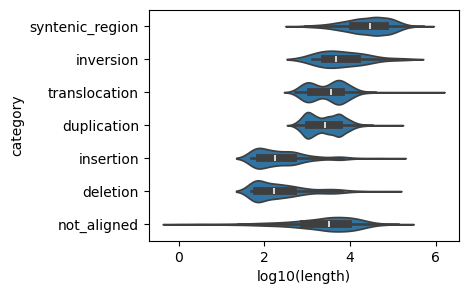

In [391]:
plt.figure(figsize=(4,3))
category_order = ['syntenic_region', 'inversion', 'translocation', 'duplication', 'insertion', 'deletion', 'not_aligned']
syri_refined['category'] = pd.Categorical(syri_refined['category'], categories=category_order, ordered=True)
sns.violinplot(data=syri_refined, y="category", x="log10(length)",
               order=category_order)

In [380]:
#sns.violinplot(data=syri_refined[~syri_refined["category"].isin(["insertion", "deletion"])], x="category", y="log10(length)")
plt.figure(figsize=(4,3))
syri_refined["category"].unique()
#sns.violinplot(data=syri_refined, y="category", x="log10(length)", linewidth=0.8, width=1, palette="Blues")

array(['syntenic_region', 'inversion', 'not_aligned', 'translocation',
       'duplication', 'insertion', 'deletion'], dtype=object)

<Figure size 400x300 with 0 Axes>

Check if stats match syri.summary 

In [358]:
syri_refined.groupby("category")["ref_len"].sum()

category
deletion             530713
duplication         4223219
insertion                 0
inversion            299021
not_aligned         9726962
syntenic_region    60169458
translocation       3329389
Name: ref_len, dtype: Int64

In [359]:
syri_refined.groupby("category")["query_len"].sum()

category
deletion                  0
duplication         2490040
insertion            636495
inversion            278724
not_aligned         9084758
syntenic_region    60051366
translocation       3182372
Name: query_len, dtype: Int64

Summary table

In [397]:
syri_refined.groupby("category")["length"].describe()

/tmp/ipykernel_2474767/2933128757.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  syri_refined.groupby("category")["length"].describe()


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
syntenic_region,1317.0,45641.922551,49233.902002,547.5,11647.50,29169.0,65204.50,504316.5
inversion,19.0,15203.815789,29319.081144,1285.0,2695.75,4698.5,14350.25,130970.5
translocation,408.0,7980.099265,50845.825668,530.0,1201.00,3654.5,5989.75,866187.5
duplication,1734.0,3871.544983,4545.076680,503.0,1119.50,2623.5,5383.00,115180.0
insertion,500.0,1272.990000,5816.461284,50.0,78.75,177.0,477.00,87486.0
deletion,524.0,1012.811069,3699.697018,50.0,68.00,172.0,474.25,68840.0
not_aligned,2703.0,6959.570847,11043.384046,1.0,822.50,3222.0,8737.00,129444.0


In [377]:
# # generate bed files
# for category in syri_split_dict.keys():
#     tmp = syri_split_dict[category]
#     tmp["ref_start"] -= 1
#     tmp["query_start"] -= 1
#     ref = tmp.iloc[:,0:3]
#     query = tmp.iloc[:,5:8]
#     ref.to_csv(f"syri_i90_l100/splitCategory/{category}.ref.bed", sep="\t", header=None, index=None)
#     query.to_csv(f"syri_i90_l100/splitCategory/{category}.query.bed", sep="\t", header=None, index=None)